In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import sklearn.cross_validation as cv

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from xgboost import XGBRegressor
import seaborn as sns
import time
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv("data.csv")

In [4]:
data.shape

(6250, 63)

In [5]:
X = data.drop(['Unnamed: 0', 'video_id', 'trending_date', 'channel_title','category_id',
               'thumbnail_link', 'publish_date','app_time','tags2','category', 'top10Channel',
               'd0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12',
               'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21', 'd22',
               'd23', 'd24'], 
               axis = 1)

In [7]:
X.shape

(6250, 27)

In [8]:
Y_class = data['app_time'] >= 2
Y_regre = data['app_time'] - 1

In [9]:
# data = data[['views', 'likes','dislikes','comment_count','comments_disabled','ratings_disabled',
#              'video_error_or_removed','date_delta','tagsLength', 'Autos & Vehicles', 'Comedy',
#              'Education', 'Entertainment', 'Film & Animation', 'Gaming', 'Howto & Style', 'Music',
#              'News & Politics', 'Nonprofits & Activism', 'People & Blogs', 'Pets & Animals', 
#              'Science & Technology', 'Shows', 'Sports','Travel & Events', 'top10Channel', 'top100Channel',
#              'top500Channel']]

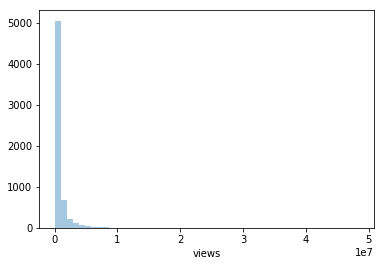

In [11]:
sns.distplot(X.views, kde=False);

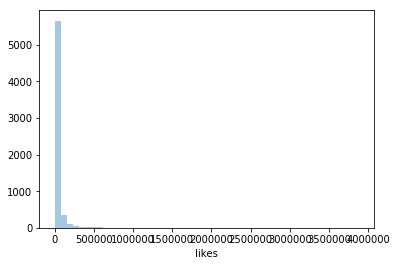

In [12]:
sns.distplot(X.likes, kde=False);

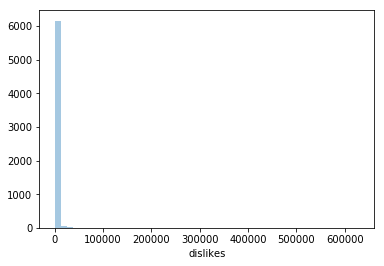

In [102]:
sns.distplot(X.dislikes, kde=False);

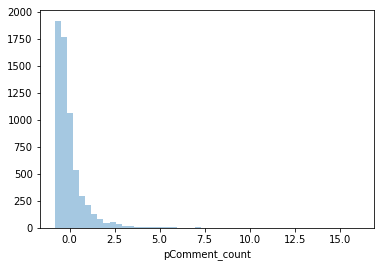

In [172]:
sns.distplot(X.pComment_count, kde=False);

In [13]:
sum(X.comment_count == 0)

131

In [14]:
sum(X.likes == 0)

26

In [15]:
sum(X.dislikes == 0)

82

In [17]:
X.dtypes

views                     int64
likes                     int64
dislikes                  int64
comment_count             int64
comments_disabled          bool
ratings_disabled           bool
video_error_or_removed     bool
date_delta                int64
tagsLength                int64
Autos & Vehicles          int64
Comedy                    int64
Education                 int64
Entertainment             int64
Film & Animation          int64
Gaming                    int64
Howto & Style             int64
Music                     int64
News & Politics           int64
Nonprofits & Activism     int64
People & Blogs            int64
Pets & Animals            int64
Science & Technology      int64
Shows                     int64
Sports                    int64
Travel & Events           int64
top100Channel              bool
top500Channel              bool
dtype: object

In [19]:
null_columns = X.columns[X.isnull().any()]
X[null_columns].isnull().sum()

Series([], dtype: float64)

In [20]:
# df = sns.load_dataset('iris')
# sns_plot = sns.pairplot(df, hue='species', size=2.5)
# sns_plot.savefig("output.png")

In [21]:
sum(Y_class)

5558

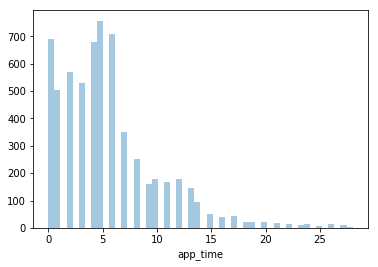

In [22]:
sns.distplot(Y_regre, kde=False);

In [23]:
data_regre = X.copy()
data_regre['Y_regre'] = Y_regre
data_class = X.copy()
data_class['Y_class'] = Y_class

In [25]:
data_regre.shape

(6250, 28)

In [26]:
data_class.shape

(6250, 28)

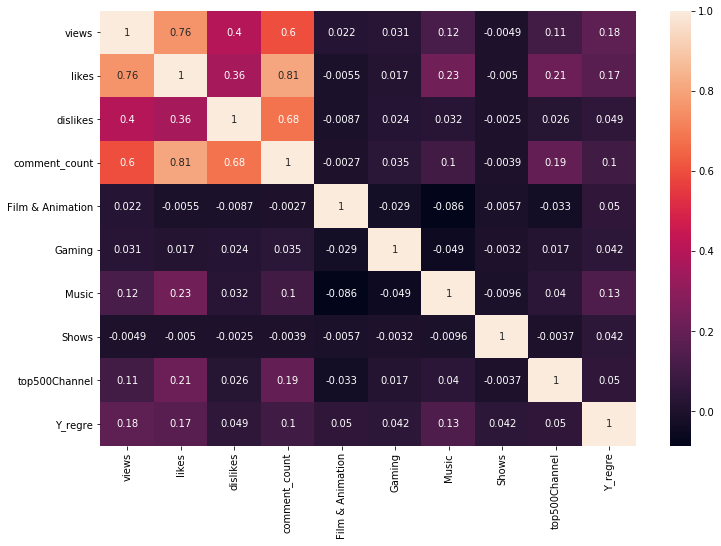

In [28]:
correlation_regre = data_regre.corr()

variables = correlation_regre.columns
important_variables = []
for row in variables:
    corrl = correlation_regre.loc[row, 'Y_regre']
    if corrl > 0.04:
        important_variables.append(row)

heatmap = correlation_regre.loc[important_variables, important_variables]
plt.figure("Heatmap-Important Variables", figsize=(12,8))
sns.heatmap(heatmap, annot=True, cbar=True);

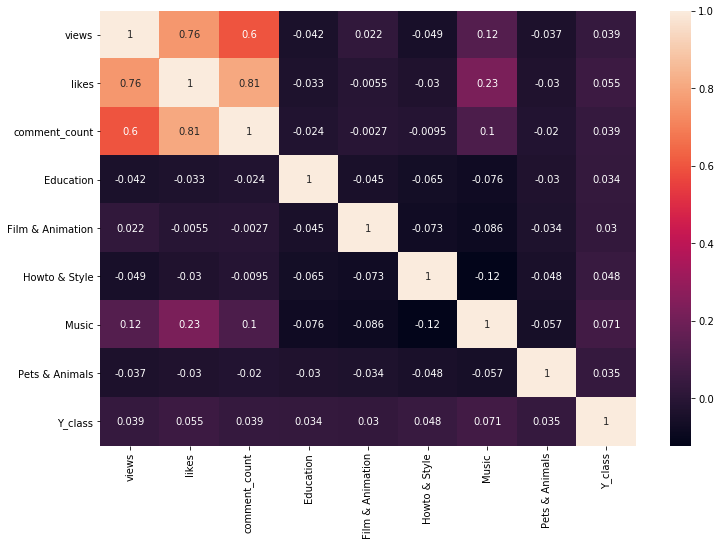

In [29]:
correlation_class = data_class.corr()

variables = correlation_class.columns
important_variables = []
for row in variables:
    corrl = correlation_class.loc[row, 'Y_class']
    if corrl > 0.03:
        important_variables.append(row)

heatmap = correlation_class.loc[important_variables, important_variables]
plt.figure("Heatmap-Important Variables", figsize=(12,8))
sns.heatmap(heatmap, annot=True, cbar=True);

## transform data

In [30]:
# standardize by views
X['pLikes'] = X['likes'] / X['views']
X['pDislikes'] = X['dislikes'] / X['views']
X['pComment_count'] = X['comment_count'] / X['views']

In [31]:
X = X.drop(['likes', 'dislikes', 'comment_count'], 
            axis = 1)

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
# con = ['date_delta','d0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 
#        'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21', 'd22', 'd23', 'd24', 'tagsLength','pLikes',
#        'pDislikes', 'pComment_count']

con = ['date_delta', 'tagsLength','pLikes',
       'pDislikes', 'pComment_count']

cat = ['comments_disabled', 'ratings_disabled',  'ratings_disabled','Autos & Vehicles', 'Comedy', 'Education',
       'Entertainment', 'Film & Animation', 'Gaming', 'Howto & Style', 'Music',
       'News & Politics', 'Nonprofits & Activism', 'People & Blogs',
       'Pets & Animals', 'Science & Technology', 'Shows', 'Sports',
       'Travel & Events', 'top100Channel', 'top500Channel',]

In [39]:
scaler = StandardScaler()
X[con] = scaler.fit_transform(X[con])

In [40]:
print(scaler.mean_)

[2.17232000e+00 2.00092800e+01 4.08327228e-02 1.73455764e-03
 5.71601430e-03]


In [44]:
data_regre = X.copy()
data_regre['Y_regre'] = Y_regre
data_class = X.copy()
data_class['Y_class'] = Y_class

In [45]:
data_regre.shape

(6250, 28)

In [70]:
data_regre.dtypes

views                       int64
comments_disabled            bool
ratings_disabled             bool
video_error_or_removed       bool
date_delta                float64
tagsLength                float64
Autos & Vehicles            int64
Comedy                      int64
Education                   int64
Entertainment               int64
Film & Animation            int64
Gaming                      int64
Howto & Style               int64
Music                       int64
News & Politics             int64
Nonprofits & Activism       int64
People & Blogs              int64
Pets & Animals              int64
Science & Technology        int64
Shows                       int64
Sports                      int64
Travel & Events             int64
top100Channel                bool
top500Channel                bool
pLikes                    float64
pDislikes                 float64
pComment_count            float64
Y_regre                     int64
dtype: object

In [46]:
data_class.shape

(6250, 28)

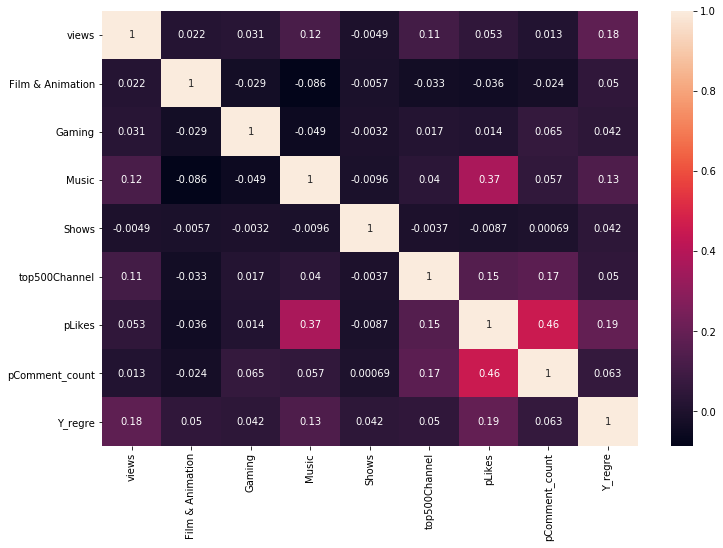

In [47]:
correlation_regre = data_regre.corr()

variables = correlation_regre.columns
important_variables = []
for row in variables:
    corrl = correlation_regre.loc[row, 'Y_regre']
    if corrl > 0.04:
        important_variables.append(row)

heatmap = correlation_regre.loc[important_variables, important_variables]
plt.figure("Heatmap-Important Variables", figsize=(12,8))
sns.heatmap(heatmap, annot=True, cbar=True);

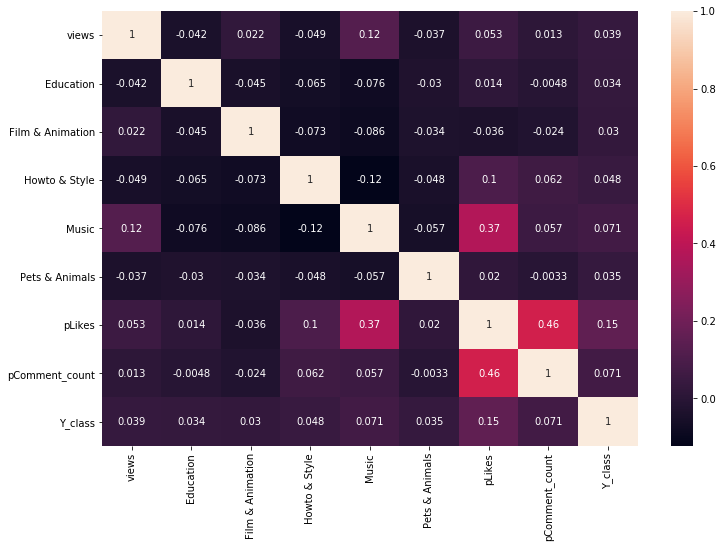

In [48]:
correlation_class = data_class.corr()

variables = correlation_class.columns
important_variables = []
for row in variables:
    corrl = correlation_class.loc[row, 'Y_class']
    if corrl > 0.03:
        important_variables.append(row)

heatmap = correlation_class.loc[important_variables, important_variables]
plt.figure("Heatmap-Important Variables", figsize=(12,8))
sns.heatmap(heatmap, annot=True, cbar=True);

In [ ]:
## outliers

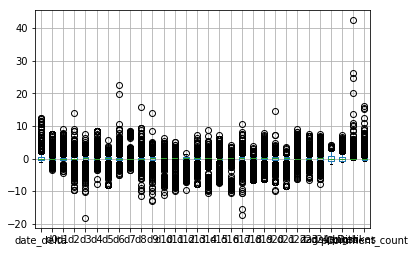

In [196]:
boxplot = X.boxplot(column = con)

In [51]:
# X_category = X.copy()
# X_category['category'] = data.category
# X_category['Y_regre'] = Y_regre
# X_category = X_category[['category', 'Y_regre']]

In [52]:
# boxplot = X_category.boxplot(column=['Y_regre'], by = ['category'])

In [53]:
X_category.groupby(['category']).size()

category
Autos & Vehicles           64
Comedy                    544
Education                 241
Entertainment            1597
Film & Animation          304
Gaming                    101
Howto & Style             590
Music                     790
News & Politics           502
Nonprofits & Activism      14
People & Blogs            490
Pets & Animals            136
Science & Technology      370
Shows                       4
Sports                    444
Travel & Events            59
dtype: int64

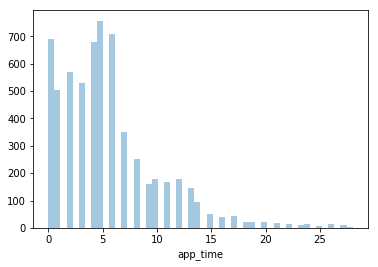

In [54]:
sns.distplot(Y_regre, kde=False);

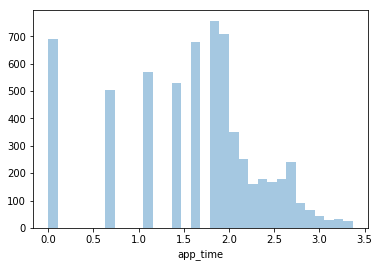

In [55]:
Y_regre_1 = data['app_time']
Y_regre_log = np.log(Y_regre_1)

sns.distplot(Y_regre_log, kde=False);

In [56]:
class ML_models():
 
    def __init__(self, x_train, y_train, x_test, y_test, model, model_param):
        
        self.x_train = x_train # x train
        self.y_train = y_train # y train
        self.x_test = x_test   # x test
        self.y_test = y_test   # y test
        self.model = model     # model name in Python
        self.model_param = model_param  # hyperparameter in model
        
    def train(self):
        '''train the model'''
        
        global model
        model = self.model + "()"
        model = eval(model)
        
        # use GridSearchCV tuning the hyperparameter
        model_grid = GridSearchCV(estimator = model, 
                                  param_grid = self.model_param, 
                                  scoring='neg_mean_squared_error',
                                  n_jobs=4,
                                  cv=5)
        
        # record the start tuning time
        start_time_grid = time.time()
        
        # start tuning model 
        model_grid.fit(self.x_train, self.y_train)
        
        # calculate total GridSearchCV time
        total_time_grid = time.time() - start_time_grid
        
        print("The total GridSearchCV training time:", round(total_time_grid, 5))

        print("The best hyperparameter:", model_grid.best_params_) 
        print("The best score of GridSearchCV training:", round(model_grid.best_score_, 5))
        print("<--------------------------------------->")
        
        # set the best tuning model parameter
        model.set_params(**model_grid.best_params_)
        
        # record the start train time
        start_time_train = time.time()
          
        # fit the model using the whole data set 
        model.fit(self.x_train, self.y_train)
        
        # calculate the mean and std of the cv error
        model_score = cross_val_score(model, self.x_train, self.y_train,
                                      cv = 5, scoring = "neg_mean_squared_error")
        
        # calculate total re-train time
        time_retrain = time.time() - start_time_train
        
        print("The re-train time:", round(time_retrain, 5))
        print("The mean of CV score of the best training model:", round(model_score.mean(), 5))
        print("The std of CV score of the best training model:", round(model_score.std(), 5))
        print("<--------------------------------------->")
        
        return model_score.mean(), model_score.std(), model
        
    def predict(self):
        '''predict the model'''
        
        start_time_prediction = time.time()
        global y_pred
        
        # predict use test data
        y_pred = model.predict(self.x_test)
        
        # using mean_squared_error because we use regression.
        score = mean_squared_error(self.y_test,y_pred)
        
        total_time_prediction = time.time() - start_time_prediction
        
        print("The total test time:", round(total_time_prediction, 5))
        print("The score of prediction:", round(score, 5))
        
        return score, y_pred
    
    def plot_y(self):
        '''plot relationship between predict value and true value'''
        
        x, y = y_pred, self.y_test
        fig, ax = plt.subplots()
        ax.scatter(x, y, c = 'blue')
        line = mlines.Line2D([0, 1], [0, 1], color = 'red')
        transform = ax.transAxes
        line.set_transform(transform)
        ax.add_line(line)
        plt.xlabel('y_pred_label')
        plt.ylabel('y_true_label')
        plt.show()

# Y_regre

In [59]:
x_train, x_test, y_train, y_test=train_test_split(X, Y_regre, test_size=0.25, random_state=0)

print("The shape of the training data:", x_train.shape, y_train.shape)
print("The shape of the test data:", x_test.shape, y_test.shape)

The shape of the training data: (4687, 27) (4687,)
The shape of the test data: (1563, 27) (1563,)


In [60]:
lasso = ML_models(x_train, y_train, x_test, y_test, 
                  "Lasso", 
                  model_param = {"alpha": [1, 0.1, 0.001, 0.0005], # constant that multiplies the L1 term - penalty 
                                 "fit_intercept": [True,False],    # whether to calculate the intercept for this model
                                 "normalize": [True,False]})       # whether to normalize the regressors X 
lasso_train = lasso.train()
lasso_predict = lasso.predict()

The total GridSearchCV training time: 0.71299
The best hyperparameter: {'alpha': 0.0005, 'fit_intercept': True, 'normalize': True}
The best score of GridSearchCV training: -19.62375
<--------------------------------------->
The re-train time: 0.03969
The mean of CV score of the best training model: -19.62333
The std of CV score of the best training model: 1.44821
<--------------------------------------->
The total test time: 0.00198
The score of prediction: 19.30705


In [61]:
ridge = ML_models(x_train, y_train, x_test, y_test, 
                  "Ridge", 
                  model_param = {"alpha": [1, 0.1, 0.001, 0.0005], # regularization strength
                                 "fit_intercept": [True,False],    # whether to calculate the intercept for this model
                                 "normalize": [True,False]})       # whether to normalize the regressors X
ridge_train = ridge.train()
ridge_predict = ridge.predict()

The total GridSearchCV training time: 0.7649
The best hyperparameter: {'alpha': 1, 'fit_intercept': True, 'normalize': False}
The best score of GridSearchCV training: -19.62429
<--------------------------------------->
The re-train time: 0.04573
The mean of CV score of the best training model: -19.62387
The std of CV score of the best training model: 1.45719
<--------------------------------------->
The total test time: 0.00237
The score of prediction: 19.38249


In [62]:
lasso_coef = pd.Series(lasso_train[2].coef_, index = x_train.columns)
print(abs(lasso_coef).sort_values())

comments_disabled         0.000000e+00
ratings_disabled          0.000000e+00
video_error_or_removed    0.000000e+00
Science & Technology      0.000000e+00
Pets & Animals            0.000000e+00
People & Blogs            0.000000e+00
Education                 0.000000e+00
pDislikes                 0.000000e+00
Howto & Style             0.000000e+00
views                     3.511027e-07
tagsLength                1.754626e-02
pComment_count            1.263653e-01
top500Channel             2.424643e-01
top100Channel             3.668602e-01
Autos & Vehicles          4.773430e-01
Entertainment             5.399881e-01
pLikes                    5.919990e-01
Music                     6.021821e-01
Comedy                    6.234695e-01
date_delta                6.552673e-01
Gaming                    6.878936e-01
Film & Animation          7.201400e-01
Travel & Events           7.421471e-01
News & Politics           1.166401e+00
Sports                    1.528188e+00
Nonprofits & Activism    

In [63]:
r2_score(y_test, lasso_predict[1])

0.08430907940427512

In [64]:
r2_score(y_test, ridge_predict[1])

0.08073073793305485

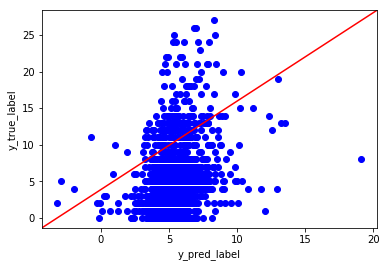

In [65]:
ridge.plot_y()

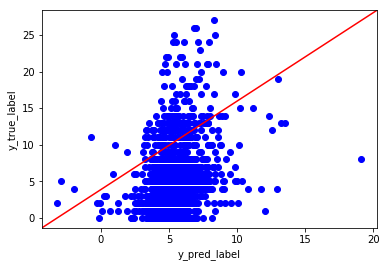

In [66]:
lasso.plot_y()

In [67]:
# lasso_coef = pd.Series(lasso_train[2].coef_, index = x_train.columns)
# print(abs(lasso_coef).sort_values())

# Y class

In [71]:
x_train, x_test, y_train, y_test=train_test_split(X, Y_class, test_size=0.25, random_state=0)

print("The shape of the training data:", x_train.shape, y_train.shape)
print("The shape of the test data:", x_test.shape, y_test.shape)

The shape of the training data: (4687, 27) (4687,)
The shape of the test data: (1563, 27) (1563,)


In [72]:
lasso = ML_models(x_train, y_train, x_test, y_test, 
                  "Lasso", 
                  model_param = {"alpha": [1, 0.1, 0.001, 0.0005], # constant that multiplies the L1 term - penalty 
                                 "fit_intercept": [True,False],    # whether to calculate the intercept for this model
                                 "normalize": [True,False]})       # whether to normalize the regressors X 
lasso_train = lasso.train()
lasso_predict = lasso.predict()

The total GridSearchCV training time: 0.59272
The best hyperparameter: {'alpha': 0.0005, 'fit_intercept': True, 'normalize': False}
The best score of GridSearchCV training: -0.09293
<--------------------------------------->
The re-train time: 0.04133
The mean of CV score of the best training model: -0.09293
The std of CV score of the best training model: 0.00746
<--------------------------------------->
The total test time: 0.00207
The score of prediction: 0.09988


In [73]:
ridge = ML_models(x_train, y_train, x_test, y_test, 
                  "Ridge", 
                  model_param = {"alpha": [1, 0.1, 0.001, 0.0005], # regularization strength
                                 "fit_intercept": [True,False],    # whether to calculate the intercept for this model
                                 "normalize": [True,False]})       # whether to normalize the regressors X
ridge_train = ridge.train()
ridge_predict = ridge.predict()

The total GridSearchCV training time: 0.58942
The best hyperparameter: {'alpha': 1, 'fit_intercept': True, 'normalize': False}
The best score of GridSearchCV training: -0.09306
<--------------------------------------->
The re-train time: 0.03565
The mean of CV score of the best training model: -0.09306
The std of CV score of the best training model: 0.0075
<--------------------------------------->
The total test time: 0.00212
The score of prediction: 0.1003


In [74]:
lasso_coef = pd.Series(lasso_train[2].coef_, index = x_train.columns)
print(abs(lasso_coef).sort_values())

Music                     0.000000e+00
top500Channel             0.000000e+00
ratings_disabled          0.000000e+00
video_error_or_removed    0.000000e+00
top100Channel             0.000000e+00
Shows                     0.000000e+00
Autos & Vehicles          0.000000e+00
Science & Technology      0.000000e+00
People & Blogs            0.000000e+00
Nonprofits & Activism     0.000000e+00
Howto & Style             0.000000e+00
Gaming                    0.000000e+00
views                     4.160566e-09
pDislikes                 2.882987e-03
tagsLength                2.943866e-03
pComment_count            2.947360e-03
Travel & Events           7.619599e-03
Education                 1.341588e-02
Film & Animation          1.791709e-02
date_delta                2.596197e-02
Pets & Animals            2.786534e-02
comments_disabled         2.947984e-02
pLikes                    3.457381e-02
Comedy                    6.892813e-02
Entertainment             7.081953e-02
News & Politics          

In [75]:
r2_score(y_test, lasso_predict[1])

0.029219339738160044

In [76]:
r2_score(y_test, ridge_predict[1])

0.025158157363933564

In [294]:
from sklearn.linear_model import SGDRegressor

SGDR = SGDRegressor()
SGDR.fit(x_train, y_train)

y_pred_SGDR = SGDR.predict(x_test)

print(mean_squared_error(y_test, y_pred_SGDR))
print(mean_absolute_error(y_test, y_pred_SGDR))
print(r2_score(y_test, y_pred_SGDR))

5.824881778823504e+40
9.08180852567965e+19
-2.7626139416336345e+39


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

logreg = LogisticRegression()
logreg.fit(x_train, y_train)

y_pred_logis = logreg.predict(x_test)

print(mean_squared_error(y_test, y_pred_logis))
print(mean_absolute_error(y_test, y_pred_logis))
print(r2_score(y_test, y_pred_logis))

## PCR

In [111]:
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

In [114]:
pd.DataFrame(pca.components_.T).shape

(52, 52)

In [113]:
pd.DataFrame(pca.components_.T).loc[:4,:5]

,0,1,2,3,4,5
0,0.023142,-0.013048,0.477111,-0.003958,0.062032,-0.027204
1,0.036133,-0.018424,0.521738,0.005167,0.026394,-0.001538
2,0.023631,0.017143,0.390847,-0.006114,0.095607,0.019755
3,0.030279,0.001601,0.532788,0.005418,0.048759,0.058676
4,-0.007139,0.015893,-0.018937,-0.031719,0.222248,0.146651


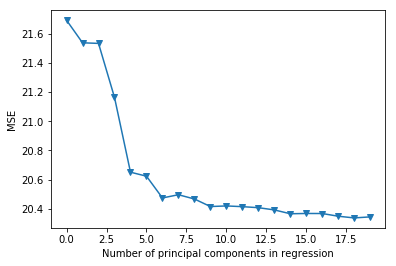

In [262]:
# Scale the data
pca = PCA()
X_reduced_train = pca.fit_transform(scale(x_train))
n = len(X_reduced_train)

# 5-fold CV, with shuffle
kf_5 = model_selection.KFold(n_splits=5, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), 
                                           y_train.ravel(), 
                                           cv=kf_5, 
                                           scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*model_selection.cross_val_score(regr, X_reduced_train[:,:i], 
                                               y_train.ravel(), 
                                               cv=kf_5, 
                                               scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.xlim(xmin=-1);

In [263]:
X_reduced_test = pca.transform(scale(x_test))

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:, :19], y_train)

# Prediction with test data
y_pred_pca = regr.predict(X_reduced_test[:, :19])
print(mean_squared_error(y_test, y_pred_pca))
print(mean_absolute_error(y_test, y_pred_pca))
print(r2_score(y_test, y_pred_pca))

19.714640875904216
3.337653705836509
0.06497773163262688


In [264]:
def plot_true_pred(y_test, y_pred):
    x, y = y_test, y_pred
    fig, ax = plt.subplots()
    ax.scatter(x, y, c = 'blue')
    line = mlines.Line2D([0, 1], [0, 1], color = 'red')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    plt.xlabel('y_pred_label')
    plt.ylabel('y_true_label')
    plt.show()

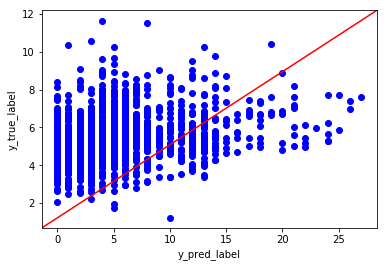

In [265]:
plot_true_pred(y_test, y_pred_pca)

## Robust Regression

In [231]:
from sklearn import linear_model

In [266]:
# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(x_train, y_train)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
y_pred_ransac = ransac.predict(x_test)

print(mean_squared_error(y_test, y_pred_ransac))
print(mean_absolute_error(y_test, y_pred_ransac))
print(r2_score(y_test, y_pred_pca))

89.51812454583585
6.001783759738266
0.06497773163262688


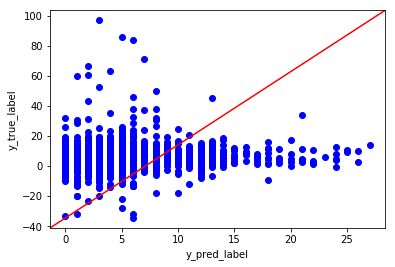

In [267]:
plot_true_pred(y_test, y_pred_ransac)

In [310]:
from scipy import stats
print(stats.shapiro(Y_regre))
print(stats.shapiro(Y_regre_log))

(0.8833138346672058, 0.0)
(0.9449359774589539, 2.718519020790145e-43)


## Model Selection

In [305]:
from sklearn.linear_model import LassoLarsIC

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(x_train, y_train)

y_pred_model_aic = model_aic.predict(x_test)

print(mean_squared_error(y_test, y_pred_model_aic))
print(mean_absolute_error(y_test, y_pred_model_aic))
print(r2_score(y_test, y_pred_model_aic))

19.200740930245644
3.2823692248362346
0.08935088130997348


In [308]:
model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(x_train, y_train)

y_pred_model_bic = model_bic.predict(x_test)

print(mean_squared_error(y_test, y_pred_model_bic))
print(mean_absolute_error(y_test, y_pred_model_bic))
print(r2_score(y_test, y_pred_model_bic))

19.253564956464995
3.2818857126342187
0.08684555335950173
